## Intermediate Machine Learning: Assignment 1

**Deadline**

Assignment 1 is due Thursday, September 25 11:59 pm. Late work will not be accepted as per the course policies (see the syllabus on Canvas).

Directly sharing answers is not okay, but discussing problems with the course staff or with other students is encouraged. Acknowledge any use of an AI system such as ChatGPT or Copilot.

You should start early so that you have time to get help if you're stuck. The drop-in office hours schedule can be found on Canvas. You can also post questions or start discussions on Ed Discussion. The assignment may look long at first glance, but the problems are broken up into steps that should help you to make steady progress.

**Submission**

Submit your assignment as a .pdf on Gradescope. You can access Gradescope through Canvas on the left-side of the class home page. The problems in each homework assignment are numbered. Note: When submitting on Gradescope, please select the correct pages of your pdf that correspond to each problem. This will allow graders to more easily find your complete solution to each problem.

To produce the .pdf, please do the following in order to preserve the cell structure of the notebook:

Go to "File" at the top-left of your Jupyter Notebook
Under "Download as", select "HTML (.html)"
After the .html has downloaded, open it and then select "File" and "Print" (note you will not actually be printing)
From the print window, select the option to save as a .pdf

**Topics**

 * Lasso
 * Bias-variance decomposition
 * Mercer kernels
 * LOOCV for kernel smoothing and ridge regression

This assignment will also help to solidify your Python and Jupyter notebook skills.


### Problem 1: Roping variables with the lasso (15 points)

In this exercise, we'll employ the lasso regression technique to identify key predictor variables from the diabetes dataset. This dataset is used in the study by Efron, Hastie, Johnstone, and Tibshirani (2004, *Annals of Statistics*, "Least Angle Regression"). The primary goal is to predict a quantitative measure of diabetes progression one year after baseline, based on ten standardized physiological and biochemical measurements.


The *Diabetes* dataset in the `sklearn.datasets` package is a classic benchmark for regression. It contains 442 samples with 10 features that have been centered to mean zero but not scaled to unit variance. The predictors include age, sex, body mass index (BMI), blood pressure (BP), and six blood serum measures (s1–s6: cholesterol, LDL, HDL, cholesterol/HDL ratio, triglycerides, and blood sugar). The target is a quantitative measure of diabetes progression one year after baseline. You can find details at https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset.

**Your tasks are as follows**:

1. **Plotting Lasso Paths**: Generate a visualization of the lasso regularization paths.
2. **Identifying Key Predictors**: Determine which coefficients of \( \beta \) are non-zero.
3. **Estimating Coefficients**: Provide the best estimate for these non-zero coefficients.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import Lasso
from sklearn.datasets import load_diabetes
%matplotlib inline

Just run the next cell to read in the data.

In [4]:
# Insert this code just above problem 1.1
X, y = load_diabetes(return_X_y=True)
n, p = X.shape
print("Number of rows: {}".format(n))
print("Number of columns: {}".format(p))
# Note that X, y = load_diabetes(return_X_y=True) has already been standardized.
# You can explore the raw data with the following code:
X_raw, y_raw = load_diabetes(return_X_y=True, scaled=False)
print(np.allclose(y, y_raw))
print(np.allclose(X/np.std(X,axis=0), (X_raw - np.mean(X_raw, axis=0)) / np.std(X_raw, axis=0)))
# The above two print statements should both return True.

Number of rows: 442
Number of columns: 10
True
True


### 1.1: Lasso regularization paths

Run the lasso and plot the regularization paths. You can use the `Lasso` class from the `sklearn.linear_model` package. Plot the parameter paths with the regularization level $\lambda$ (`alpha` in the code) on the log-scale, as done in the lasso demo code from class. (As always, be sure to label your axes.)

Show two plots, one where you run the lasso on the variables as given in the dataset, another where you standardize the variables to have mean zero and standard deviation one. Describe the differences in the regularization paths, and explain those differences.

When the predictors are standardized, what order do they appear in the lasso fits? That is, as $\lambda$ decreases from infinity to zero, what is the sequence of variables that enter the model with nonzero coefficients? Explain why this ordering may (or may not) make sense.


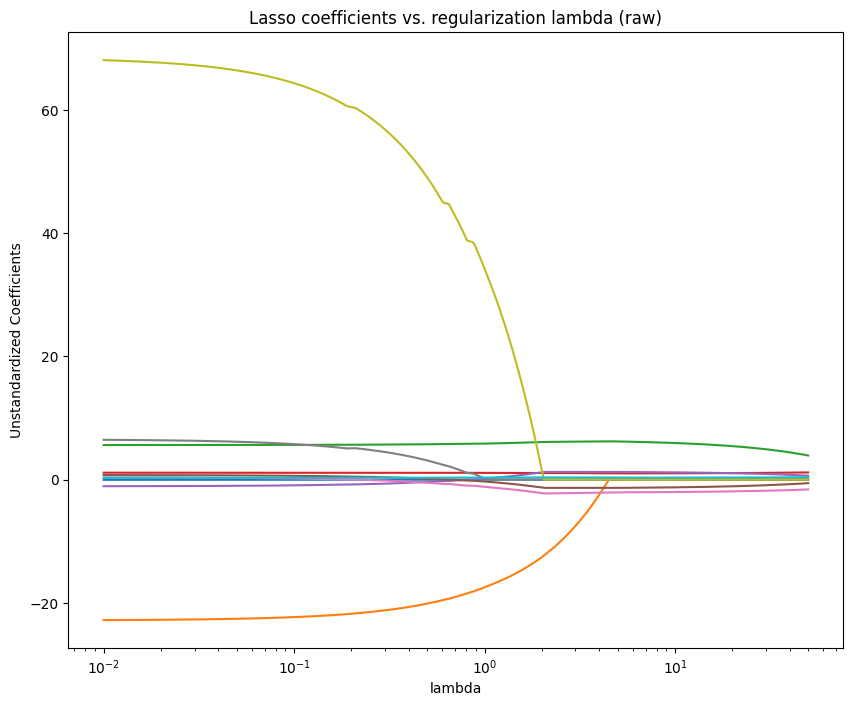

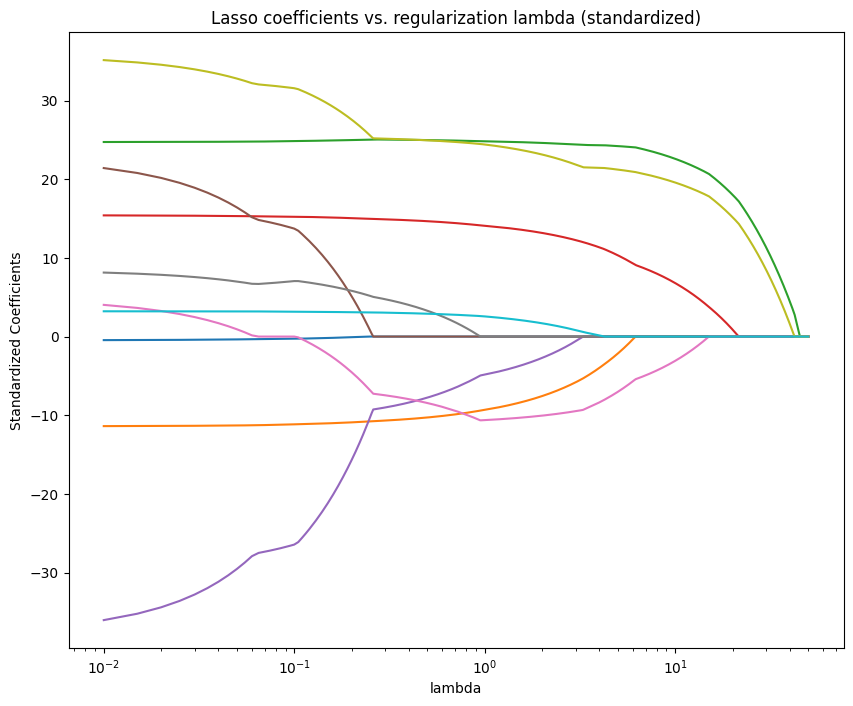

In [5]:
alphas = np.linspace(0.01,50,10000)
lasso = Lasso()
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_raw, y_raw)
    coefs.append(lasso.coef_)

plt.figure(figsize=(10,8))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('lambda')
plt.ylabel('Unstandardized Coefficients')
plt.title('Lasso coefficients vs. regularization lambda (raw)');

ys = y_raw - np.mean(y_raw)
Xs = (X_raw - np.mean(X_raw, axis=0)) / np.std(X_raw, axis=0)
lasso=Lasso()
coefs=[]

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(Xs, ys)
    coefs.append(lasso.coef_)

plt.figure(figsize=(10,8))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('lambda')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients vs. regularization lambda (standardized)');




In the raw model, we see that the lasso is heavily dominated by two features until around $\lambda = 10^0$, while the other coefficients remain near zero. Comparatively, in the standardized model, the coefficients and distributed much more evenly. Additionally, most featuers do reach $0$, showing that the model is less biased towards variables with larger units. The ordering in the standardized model is also different than in the raw modle, likely a result of standardization putting all predictors on the same scale, so entry is driven by predictive strength rather than raw units.

In [6]:
feature_names = load_diabetes().feature_names

coefs = np.asarray(coefs)
alphas = np.asarray(alphas)
feat = np.asarray(feature_names)

rows = []
for i in range(coefs.shape[1]):
    nz = np.flatnonzero(np.abs(coefs[:, i]) > 0)
    if nz.size:
        rows.append((i, feat[i], alphas[nz[-1]]))   # last nonzero along increasing alphas

entry_df = pd.DataFrame(rows, columns=["feature_index","feature","entry_alpha"])
entry_df = entry_df.sort_values("entry_alpha", ascending=False, ignore_index=True)
entry_df.insert(0, "rank", np.arange(1, len(entry_df)+1))
entry_df

,rank,feature_index,feature,entry_alpha
0,1,2,bmi,45.155485
1,2,8,s5,42.295771
2,3,3,bp,21.537847
3,4,6,s3,15.033497
4,5,1,sex,6.184382
5,6,9,s6,4.219579
6,7,4,s1,3.279673
7,8,7,s4,0.949906
8,9,5,s2,0.254975
9,10,0,age,0.239977


The first variables in the ordering are bmi, s5, and bp, which are all features that would be heavily associated with diabetes progression. Meanwhile, things like age are comparatively weak once physiological measures are in, so it makes since for it to be last.

### 1.2: Select, estimate, and predict

The true model is linear, and only a subset $S \subset \{0,1,\ldots, 9\}$ of the 10 variables have non-zero coefficients $\beta_j$. In this problem you should make three estimates:

1. An estimate $\hat S$ of $S$
2. An estimate $\hat \beta_j$ for each $j\in \hat S$
3. An estimate of the predictive risk ${\mathbb E}(Y - X\hat\beta)^2$


We are not specifying how you should construct these estimates. You should use your judgement, taste, and
the tools provided from class. However, you must clearly explain and justify whatever approach that you use.


In [7]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import LeaveOneOut

alphas = np.logspace(-3, 2, 300)
loocv = LeaveOneOut()
lasso_cv = LassoCV(alphas=alphas, cv=loocv, fit_intercept=False, max_iter=100000)
lasso_cv.fit(Xs, ys)

alpha_hat = lasso_cv.alpha_
beta_std  = lasso_cv.coef_
S_hat_idx = np.flatnonzero(np.abs(beta_std) > 0)

feature_names = np.array(feature_names)
S_hat = feature_names[S_hat_idx].tolist()

print(f"alpha_hat (LOOCV): {alpha_hat}")
print("Ŝ (features selected):", S_hat)

alpha_hat (LOOCV): 1.0635449574860112
Ŝ (features selected): ['sex', 'bmi', 'bp', 's1', 's3', 's5', 's6']


In this segment, I estimated alpha using LOOCV, testing values from a logarithmically spaced grid ranging from $10^{-3}$ to $10^2$. For each candidate, the lasso model was fit on $n-1$ observations and evaluated on the single left-out point, with the process repeated across all $n$ data points. The optimized alpha was found to be around 1.06. Afterwards, I estimated $\hat S$ by fitting the lasso regression to this alpha value and checking which coefficients were non-zero. These turned out to be sex, bmi, bp, s1, s3, s5, and s6.

In [8]:
from sklearn.linear_model import LinearRegression

features = Xs[:, S_hat_idx]

lr = LinearRegression()
lr.fit(features, ys)

print(lr.coef_)

[-11.07046071  25.04017589  15.00012415  -6.96099267 -11.19192426
  25.69394378   3.43337959]


These are the estimates $\hat B_j$ given the selected non-zero features and alpha value.

In [9]:
from sklearn.model_selection import cross_val_score

model = Lasso(alpha=alpha_hat, fit_intercept=False, max_iter=100000)
scores = -cross_val_score(model, Xs, ys, cv=LeaveOneOut(), scoring="neg_mean_squared_error")
risk_hat = scores.mean()

print(f"Estimated predictive risk: {risk_hat:.4f}")

Estimated predictive risk: 2980.0165


Finally, we performed LOOCV once again by iteratively leaving out each observation, fitting the lasso model at the chosen $\hat \alpha$ on the remaining data, predicting the held-out point, and averaging the squared prediction errors to estimate the model’s predictive risk.

### Problem 2: Risky business (10 points)

In class [(and in these notes)](https://github.com/YData123/sds365-fa22/raw/main/notes/kernel-bias-variance.pdf) we sketched a proof that, when the regression function has two bounded derivatives,
 the bias and variance for kernel smoothing scale as

$$ \mbox{bias}^2 = O\left(h^4\right)$$
$$ \mbox{var} = O\left(\frac{1}{nh^p}\right).$$

Here $h$ is the bandwidth parameter, $n$ is the sample size, and $p$ is the number of predictor variables. These expressions are asymptotic, meaning that they apply as $n$ gets large and $h$ gets small.  In this problem your job is to reason about the implications of this bias-variance decomposition for prediction.

*Note:* For this problem, you may either enter your answers in Markdown using $\rm\LaTeX$, or you write them on paper and scan to insert as an image in the notebook; whichever you prefer.


### 2.1 Selecting the optimal bandwidth

Suppose that the bias and variance are such that

$$ \mbox{bias}^2(\hat m(x))  \leq c_1 h^4 $$
$$ \mbox{var}(\hat m(x)) \leq c_2 \frac{1}{nh^p}.$$

for two constants $c_1$ and $c_2$. Using these expressions and a little calculus, determine the optimal bandwidth $h$ to minimize the risk function

$$R(h) = {\mathbb E}\left(\hat m(x) - m(x)\right)^2.$$

Your answer should involve the constants $c_1, c_2$, and $n$ and $p$. Give a bound on the resulting risk using this bandwidth.


### 2.2 Bandwith selection without tears

Now, going back to the expressions $\mbox{bias}^2 = O\left(h^4\right)$ and $ \mbox{var} = O\left(\displaystyle\frac{1}{nh^p}\right)$, explain why the scaling of the optimal bandwidth (as a function of $n$ and $p$), must satisfy
$\mbox{bias}^2  \approx \mbox{var}$; that is, they must be of the same order as $h\to 0$. Then, without using any calculus, use this argument to determine the optimal scaling of the bandwidth and the fastest rate at which the
risk $R(h) = {\mathbb E}\left(\hat m(x) - m(x)\right)^2$ can approach zero as the sample size increases.


### 2.3 The cursed COD

Using the risk bound you derive above, make a plot that demonstrates the curse of dimensionality by plotting the sample size required to achieve a given level of risk. Specifically, let the target risk $R$ vary between 0.1 and 0.5, and let the dimension $p$ vary between 1 and 20, and plot the sample size required to achieve that risk. Give a single plot that shows the collection of curves for each dimension.




# Solution 2.1

We want to minimize the risk  

$
R(h) = \mathbb{E}\big[(\hat m(x) - m(x))^2\big]
   \;\;=\;\; \text{bias}^2 + \text{var}
   \;\;\le\;\; c_1 h^{4} + \frac{c_2}{n h^{p}} .
$

We can minimize this function by differentiating with respect to $h$:

$f'(h) = 4c_1h^3 - \frac{c_2p}{n}h^{-(p+1)} = 0$

$\implies 4c_1h^{p+4} = \frac{c_2p}{n}$

$\implies h^* = (\frac{c_2p}{4c_1n})^{\frac{1}{p+4}}$.

Plugging $h^*$ back into the bounds yields

$R(h^*) \le c_1 \left(\frac{c_2 p}{4c_1 n}\right)^{\frac{4}{p+4}} + \frac{c_2}{n}\left(\frac{c_2 p}{4c_1 n}\right)^{-\frac{p}{p+4}}$

$= c_1 \left(\frac{c_2 p}{4c_1 n}\right)^{\frac{4}{p+4}} + \frac{c_2}{n}\left(\frac{4c_1 n}{c_2 p}\right)^{\frac{p}{p+4}}$

$= \left[c_1 \left(\frac{c_2 p}{4c_1}\right)^{\frac{4}{p+4}} + c_2 \left(\frac{4c_1}{c_2 p}\right)^{\frac{p}{p+4}}\right] n^{-\frac{4}{p+4}}$.

Thus at the optimal bandwidth, the predictive risk decays at the rate $n^{-\frac{1}{p+4}}$.



# Solution 2.2

Suppose the scaling of the optimal bandwidth is not balanced; i.e either bias dominates or variance dominates.

If bias dominates ($h^4 \gg \frac{1}{nh^p}$), then a small decrease in $h$ will result in a substantial decrease in bias but only a slight growth in variance, reducing risk.

Similarly, if variance dominates ($h^4 \ll \frac{1}{nh^p}$), then a small increase in $h$ will result in a substantial decrease in variance but only a slight increase in bias, reducing risk.

Thus we must have $h^4 \approx \frac{1}{nh^p} \implies h \asymp n^{-\frac{1}{4+p}}$.

Substituting this scaling back into either the bias or variance term yields the convergence rate for the risk:

$R(h_*) \asymp n^{-\frac{4}{4+p}}$.


# Solution 2.3


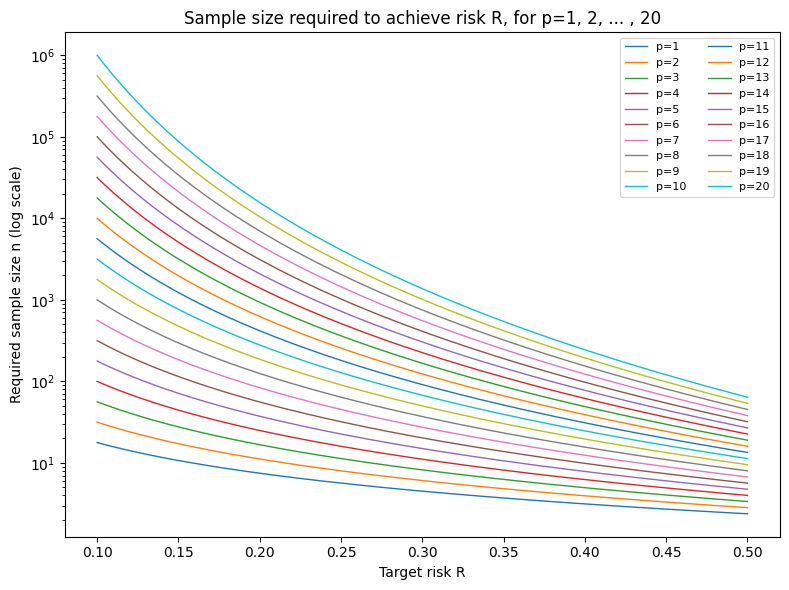

In [10]:
R = np.linspace(0.1, 0.5, 200)

plt.figure(figsize=(8,6))
for p in range(1, 21):
    n_req = (1 / R) ** ((p + 4) / 4)
    plt.plot(R, n_req, linewidth=1, label=f"p={p}")

plt.yscale('log')
plt.xlabel("Target risk R")
plt.ylabel("Required sample size n (log scale)")
plt.title("Sample size required to achieve risk R, for p=1, 2, ... , 20")
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

### Problem 3: A kernel of truth (15 points)

For problem you will implement nonparametric regression using Mercer kernels and penalization, in 1-dimension. This can be compared to regression using smoothing kernels.

As discussed in lecture, nonparametric regression with Mercer kernels is based on the infinite dimensional ridge regression

$$ \hat m = \mbox{argmin} \| Y - m \|^2 + \lambda \|m\|_K^2$$

By the representer theorem, this is equivalent to setting $\hat m(x) = \sum_{i=1}^n \hat \alpha_i K(X_i, x)$ and
using the finite dimensional optimization

$$ \hat \alpha = \mbox{argmin} \| Y - {\mathbb K} \alpha \|^2 + \lambda \alpha^T {\mathbb K} \alpha$$

###  3.1 Solve

Derive a closed-form expression for the minimizer $\hat\alpha$. Show all of the steps in your derivation,
and justify each step. (As above, you may either enter your answers in Markdown using $\rm\LaTeX$, or insert an image of your handwritten solution.)


# Solution 3.1

To solve for $\hat{\alpha}$, we take the derivative of the objective with respect to $\alpha$.  
Since $K$ is a Mercer kernel Gram matrix, it is symmetric ($K^\top = K$).

$\frac{d}{d\alpha}\Big(\|Y - K\alpha\|^2 + \lambda \alpha^\top K \alpha\Big)  
= 2(Y - K\alpha)(-K) + 2\lambda K\alpha  
= -2K(Y - K\alpha) + 2\lambda K\alpha  
= 2K(-Y + K\alpha + \lambda \alpha).$


Setting this equal to zero:

$2K(-Y + K\hat{\alpha} + \lambda \hat{\alpha}) = 0$  

$\;\;\;\;\;\Longrightarrow\; K\hat{\alpha} + \lambda \hat{\alpha} = Y$  

$\;\;\;\;\;\Longrightarrow\; (K + \lambda I)\hat{\alpha} = Y$  

$\;\;\;\;\;\Longrightarrow\; \hat{\alpha} = (K + \lambda I)^{-1}Y.$

###  3.2 Implement

Next you will use your solution above and implement Mercer kernel regression. We give some starter code.

In [46]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from time import sleep

The following cell defines some "helper functions" for this exercise. You don't need to change any of this code.
(If you do want to make changes, just describe what you did and why.)

In [47]:
def plot_estimate(x, f, fhat, X, y, sigma, lmbda, sleeptime=.01):
    clear_output(wait=True)
    plt.figure(figsize=(10,6))
    plt.plot(x, f, color='red', linewidth=2, label='true function')
    plt.plot(x, fhat, color='blue', linewidth=2, label='estimated function')
    plt.scatter(X, y, color='black', alpha=.5, label='random sample')
    plt.ylim(np.min(f)-4*sigma, np.max(f)+4*sigma)
    plt.legend(loc='upper left')
    plt.title('lambda: %.3g' % lmbda)
    plt.xlabel('x')
    plt.ylabel('estimated m(x)')
    plt.show()
    sleep(sleeptime)

def true_fn(x):
    return 3*x**2

def run_simulation(kernel, lmbdas, show_bias_variance=True):
    min_x, max_x = -1, 1
    x = np.linspace(min_x, max_x, 100)
    f = true_fn(x)
    sigma = .25
    estimates = []
    trials = 500

    for lmbda in lmbdas:
        estimates_lambda = []
        for i in np.arange(trials):
            X = np.sort(np.random.uniform(low=min_x, high=max_x, size=50))
            fX = true_fn(X)
            y = fX + sigma*np.random.normal(size=len(X))
            fhat = mercer_kernel_regress(kernel, X, y, x, lmbda=lmbda)
            if i % 50 == 0:
                plot_estimate(x, f, fhat, X, y, sigma, lmbda)
            estimates_lambda.append(fhat)
        estimates.append(estimates_lambda)

    if show_bias_variance == False:
        return

    fhat = np.array(estimates)
    sq_bias = np.zeros(len(lmbdas))
    variance = np.zeros(len(lmbdas))

    for i in np.arange(len(lmbdas)):
        sq_bias[i] = np.mean((np.mean(fhat[i], axis=0) - f)**2)
        variance[i] = np.mean(np.var(fhat[i], axis=0))

    plt.figure(figsize=(10,6))
    plt.plot(lmbdas, sq_bias, label='squared bias', linewidth=2)
    plt.plot(lmbdas, variance, label='variance', linewidth=2)
    plt.plot(lmbdas, sq_bias + variance, label='risk')
    plt.legend()
    plt.show()


Your job is to implement Mercer kernel regression and run it on two
different kernel functions. The two kernels could simply be the Gaussian kernel
with two different bandwidths, or you might experiment with other kernels.

The function `mercer_kernel_regress` takes a kernel, training data `X` and `y`, an array of values `x` to evaluate the function on, and a regularization parameter. You'll use your derivation above to
determine the coefficients $\alpha$. For some clues and suggestions on how to do the
implementation, see our demo code for smoothing kernels. You need to do something very similar.


In [52]:
def mercer_kernel_regress(kernel, X, y, x, lmbda):
    n = len(X)
    K = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            K[i][j] = kernel(X[i] - X[j])

    alpha = np.linalg.solve(K + lmbda * np.identity(n), y)

    Kx = np.zeros((len(x), n))
    for i in range(len(x)):
        for j in range(n):
            Kx[i][j] = kernel(x[i] - X[j])

    return Kx @ alpha

def kernel1(x):
    return np.exp(-(x)**2/(2*0.5**2))


def kernel2(x):
    return (1-np.abs(x)/0.5) * np.array(np.fabs(x)/0.5 < 1)

###  3.3 Run two simulations and select regularization parameters

Finally, using our starter code and your own implementation above, run two simulations, one
using `kernel1` and the other using `kernel2`. After each simulation, select a regularization level from the bias-variance tradeoff, and then run a final simulation with that regularization level. In the following
starter code, you only need to specify the sequence of regularization parameters.


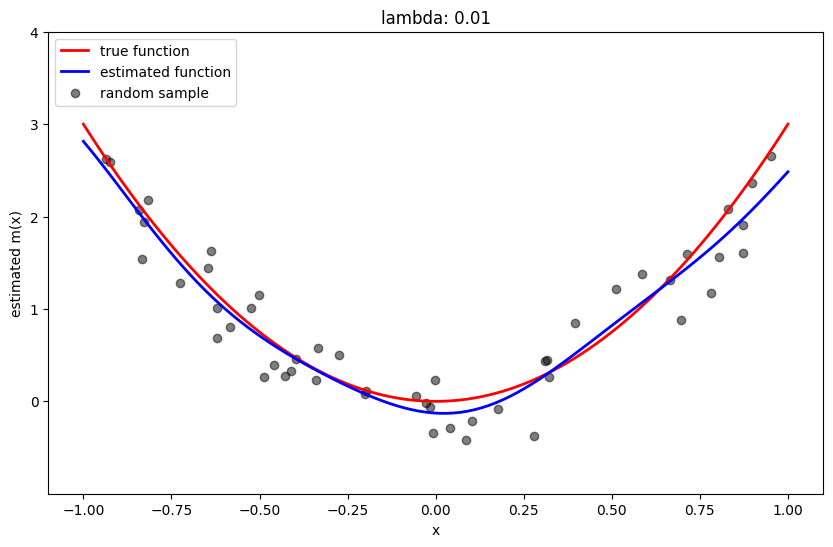

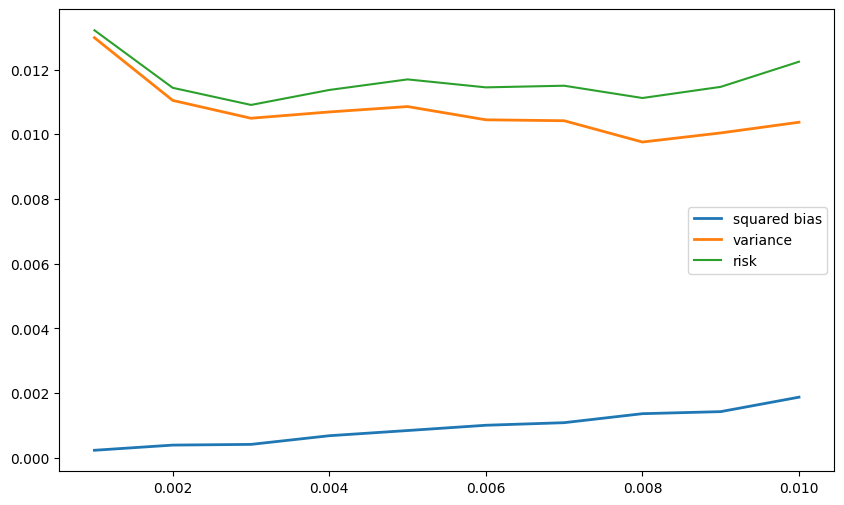

In [54]:
lmbdas = np.linspace(0.001, 0.01, 10)
run_simulation(kernel1, lmbdas)

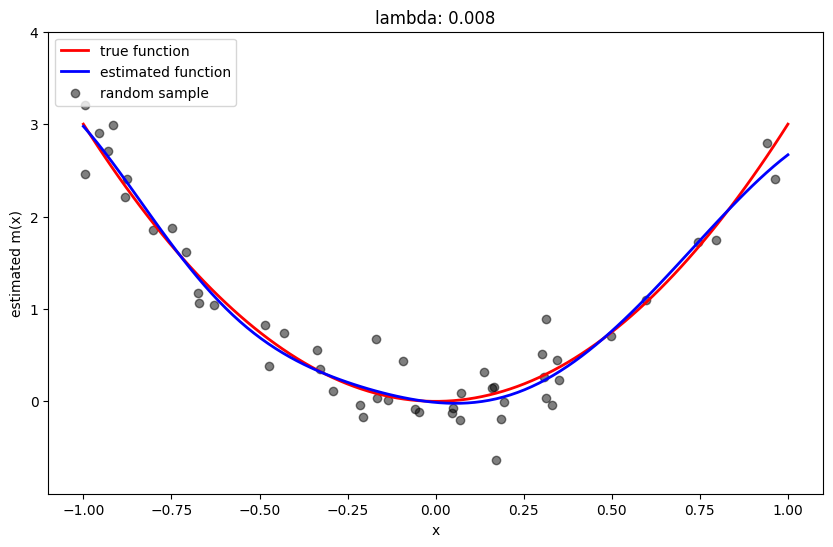

In [55]:
lambda_hat = 0.008
run_simulation(kernel1, [lambda_hat], show_bias_variance=False)

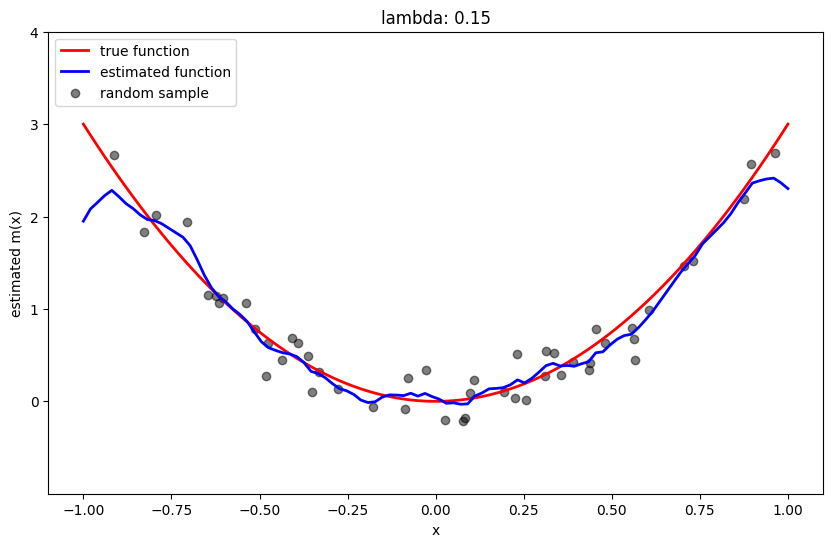

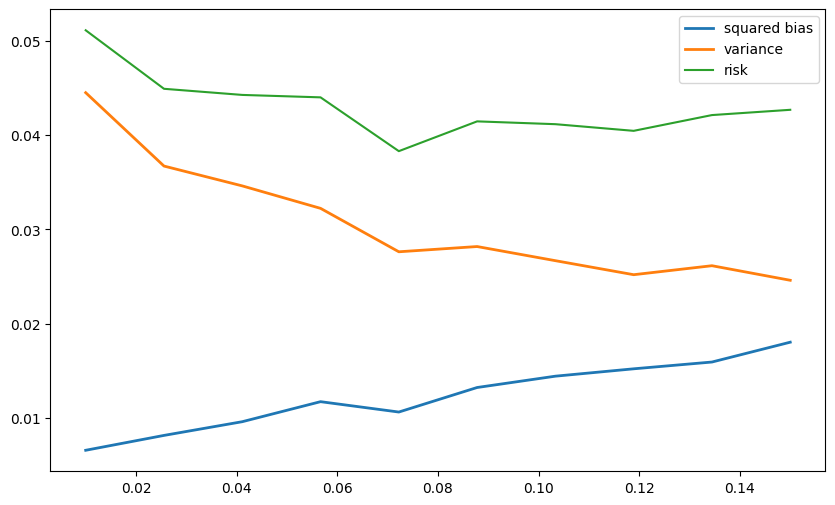

In [57]:
lmbdas = np.linspace(0.01, 0.15, 10)
run_simulation(kernel2, lmbdas)

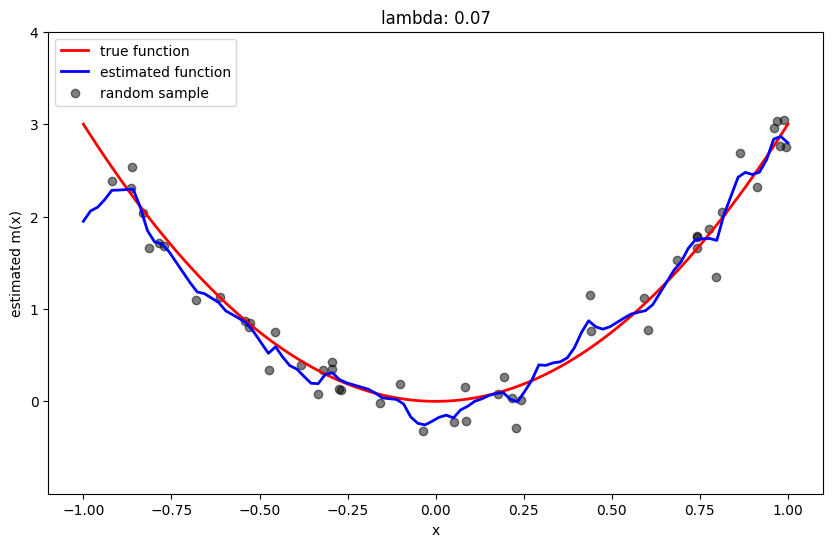

In [58]:
lambda_hat = 0.07
run_simulation(kernel2, [lambda_hat], show_bias_variance=False)

### Problem 4: An algebraic simplification of LOOCV (15 points)

Leave-One-Out Cross Validation (LOOCV) is a specific type of
$K$-fold cross validation where $K$ equals the number of observations in the dataset.
It works as follows for a training set with $n$ observations:

1. A single observation is used as the validation set,
    and the remaining $n-1$ observations serve as the training set.
2. A model is trained on the $n-1$ observations and
    validated on the single left-out observation.
3. This process is repeated $n$ times, each time leaving out a different
    observation as the validation set.
4. The LOOCV error is then the average error across all $n$ trials.

LOOCV is particularly useful because:
- It utilizes almost all the data for training,
    so it's less prone to high variance compared to other validation schemes.
- Since each observation is tested exactly once,
    LOOCV provides a very thorough out-of-sample testing mechanism.

However, it can be computationally expensive because you have to fit the model $n$ times.
    Luckily, for some models, there are algebraic simplifications available
    that make it computationally efficient.
    Expressing LOOCV in terms of the hat matrix allows for efficient
    computation of the LOOCV error without the need to refit the model for
    each left-out observation, making it a valuable tool for model evaluation.

Recall that the LOOCV error can be expressed as:

$$ LOOCV = \frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{y}_{-i} \right)^2, $$

where $\hat{y}_{-i}$ represents the prediction for the $i^{th}$ observation
when it's left out from the training process.
In the following questions, you will be deriving an alternative expression
of the LOOCV error for both kernel and ridge regression, following the hints below.

### 1. LOOCV for kernel smoothing:

For kernels, we know that the LOOCV error can be equivalently written as the following form:

$$ LOOCV = \frac{1}{n} \sum_{i=1}^{n} \left( \frac{y_i - \hat y_i}{1 - L_{ii}} \right)^2, $$
where $\hat y_i$ is the predicted value from the model fit on all data, and
$L_{ii}$ is the $i^{th}$ diagonal element of the hat matrix $L$.

For kernel regression, we have
$$ \hat{y} = L y, $$
where
- $ \hat{y} $ is the vector of predictions.
- $ y $ is the observed response values.
- $ L $ is the hat matrix and is defined by the kernel (for a given bandwidth).
So, each diagonal element $ L_{ii} $ of the matrix $ L $ is defined as:
$$ L_{ii} = \frac{K\left(x_i, x_i\right)}{\sum_{j=1}^{n} K\left(x_i, x_j\right)}, $$
where
- $ K $ is the kernel function.
- $ x_i $ and $ x_j $ are the predictor values for observations $ i $ and $ j $, respectively.

The diagonal elements $ L_{ii} $ give the "leverage" of each observation, which can be interpreted as the influence an observation has on its own prediction.

Derive this alternative expression of the LOOCV error for kernel regression. That's to say, for kernel regression, prove that

$$ y_i - \hat{y}_{-i}  =  \frac{y_i - \hat y_i}{1 - L_{ii}}$$

# Solution 4

We define, for each pair $(i,j)$, the weight  

$$L_{ij} = \frac{K(x_i, x_j)}{\sum_{k=1}^n K(x_i, x_k)},$$  

so that the diagonal entry is $L_{ii} = \frac{K(x_i, x_i)}{\sum_{k=1}^n K(x_i, x_k)}$.  

From the fitted values $\hat y = Ly$, we obtain  

$$\hat y_i = \sum_{j=1}^n L_{ij} y_j = \frac{\sum_{j=1}^n K(x_i, x_j) y_j}{\sum_{k=1}^n K(x_i, x_k)}.$$  

If we remove the $i$-th observation, the prediction becomes  

$$\hat y_{-i} = \sum_{j=1, j \ne i}^n L_{ij} y_j
= \frac{\sum_{j \ne i} K(x_i, x_j) y_j}{\sum_{k \ne i} K(x_i, x_k)}
= \frac{\Big(\sum_{j=1}^n K(x_i, x_j) y_j\Big) - K(x_i, x_i)y_i}{\Big(\sum_{k=1}^n K(x_i, x_k)\Big) - K(x_i, x_i)}.$$


Next, compare the errors.  

For the full model,  

$$y_i - \hat y_i = \frac{\sum_{k=1}^n K(x_i, x_k)y_i - \sum_{j=1}^n K(x_i, x_j)y_j}{\sum_{k=1}^n K(x_i, x_k)}.$$  

For the leave-one-out version,  

$$y_i - \hat y_{-i} = \frac{\sum_{k=1}^n K(x_i, x_k)y_i - \sum_{j=1}^n K(x_i, x_j)y_j}{\Big(\sum_{k=1}^n K(x_i, x_k)\Big) - K(x_i, x_i)}.$$  


Because the numerators are the same, their ratio depends only on the denominators:  

$$y_i - \hat y_i = \frac{\Big(\sum_{k=1}^n K(x_i, x_k)\Big) - K(x_i, x_i)}{\sum_{k=1}^n K(x_i, x_k)} \cdot (y_i - \hat y_{-i}).$$  


Now simplify $1 - L_{ii}$:  

$$1 - L_{ii} = 1 - \frac{K(x_i, x_i)}{\sum_{j=1}^n K(x_i, x_j)}
= \frac{\Big(\sum_{k=1}^n K(x_i, x_k)\Big) - K(x_i, x_i)}{\sum_{k=1}^n K(x_i, x_k)}.$$  


Substituting this expression back, we arrive at  

$$y_i - \hat y_i = (1 - L_{ii})(y_i - \hat y_{-i})
\;\;\;\Longrightarrow\;\;\; y_i - \hat y_{-i} = \frac{y_i - \hat y_i}{1 - L_{ii}}.$$

## Problem 5: LASSO and Elastic Net

In class, we derived the solution for the one-dimensional LASSO using convexity and subgradients. We also know that coordinate descent can be used to solve LASSO in the high-dimensional case. Sometimes, we introduce a penalty that is a mixture of the $\ell_1$ and $\ell_2$ norms,  

$$
\lambda_1 \|\beta\|_1 + \lambda_2 \|\beta\|_2^2,
$$  

which is referred to as the **Elastic Net**. This problem demonstrates how the Elastic Net can be computed using the LASSO.

Let us first recall the one-dimensional LASSO objective:

$$
f(\beta) = \frac{a}{2}\beta^2 - b\beta + \lambda |\beta|,
\qquad a > 0,\; \lambda \ge 0.
$$

The minimizer is given by

$$
\widehat{\beta} = \frac{\operatorname{sign}(b)\,\big(|b| - \lambda\big)_+}{a},
$$

where $(x)_+ = \max\{x,0\}$.

5.1 Solve the one-dimensional LASSO problem

$$
\widehat{\beta} = \arg\min_\beta \left\{ \frac{1}{2n}\sum_{i=1}^n (y_i - \beta x_i)^2 + \lambda |\beta| \right\},
$$

where $\lambda \geq 0$ and at least one $x_i \neq 0$.

# Solution 5.1

To find $\hat \beta$, we differentiate $\frac{1}{2n} \sum_{i=1}^n(y_i - \beta x_i)^2 + \lambda |\beta|$ with respect to $\beta$ and set it equal to $0$.

$ \displaystyle
\frac{1}{2n}\sum_{i=1}^n(y_i-\beta x_i)^2+\lambda|\beta|
=\frac{1}{2n}\left(\sum_{i=1}^n y_i^2-2\beta\sum_{i=1}^n x_i y_i+\beta^2\sum_{i=1}^n x_i^2\right)+\lambda|\beta|
$

Ignoring the constant $\frac{1}{2n}\sum y_i^2$, minimize
$g(\beta)=\frac{\beta^2}{2n}\sum_{i=1}^n x_i^2-\frac{\beta}{n}\sum_{i=1}^n x_i y_i+\lambda|\beta|.$

For $\beta>0$: $g'(\beta)=\frac{1}{n}\sum x_i^2,\beta-\frac{1}{n}\sum x_i y_i+\lambda=0
\ \Rightarrow\
\beta=\dfrac{\frac{1}{n}\sum x_i y_i-\lambda}{\frac{1}{n}\sum x_i^2},\ \text{valid if }\frac{1}{n}\sum x_i y_i>\lambda.$

For $\beta<0$: $g'(\beta)=\frac{1}{n}\sum x_i^2,\beta-\frac{1}{n}\sum x_i y_i-\lambda=0
\ \Rightarrow\
\beta=\dfrac{\frac{1}{n}\sum x_i y_i+\lambda}{\frac{1}{n}\sum x_i^2},\ \text{valid if }\frac{1}{n}\sum x_i y_i<-\lambda.$

For $\beta=0$: $0\in -\frac{1}{n}\sum x_i y_i+\lambda[-1,1]\ \Rightarrow\ \left|\frac{1}{n}\sum x_i y_i\right|\le\lambda.$

Combining these cases yields that $\hat{\beta} \;=\;
\frac{\operatorname{sign}\ \left(\tfrac{1}{n}\sum_{i=1}^n x_i y_i\right)}
{\tfrac{1}{n}\sum_{i=1}^n x_i^2}
\left( \left| \tfrac{1}{n}\sum_{i=1}^n x_i y_i \right| - \lambda \right)_+$.

5.2 Solve the one-dimensional Elastic Net
$$
\widehat{\beta} = \arg\min_\beta \left\{ \frac{1}{2n} \sum_{i=1}^n (y_i - \beta x_i)^2 + \lambda_1 |\beta| + \lambda_2 \beta^2 \right\},
$$

where $\lambda_1 \geq 0$, $\lambda_2 \geq 0$, and at least one $x_i \neq 0$.  

*Hint:* Convert this problem into the form of 5.1. What happens if we observe a new data point $(\sqrt{2n\lambda_2}, 0)$?

# Solution 5.2

Add the pseudo-observation $(\sqrt{2n\lambda_2}, 0)$.  
With this addition, the objective becomes

$ \frac{1}{2n}\sum_{i=1}^n (y_i - \beta x_i)^2 + \lambda_1|\beta| + \lambda_2 \beta^2
= \frac{1}{2n}\sum_{i=1}^n y_i^2 - \frac{1}{n}\sum_{i=1}^n y_i x_i \beta
+ \frac{1}{2n}\sum_{i=1}^n x_i^2 \beta^2 + \lambda_1|\beta|.$

Thus the coefficient of $\beta^2$ changes from $\tfrac{1}{n}\sum_{i=1}^n x_i^2$ to
$\tfrac{1}{n}\sum_{i=1}^n x_i^2 + 2\lambda_2$.  

Re-using the LASSO solution, we obtain

$ \hat{\beta} = \frac{\text{sign}\ \left(\tfrac{1}{n}\sum_{i=1}^n y_i x_i\right)}
{\tfrac{1}{n}\sum_{i=1}^n x_i^2 + 2\lambda_2}
\left(\left|\tfrac{1}{n}\sum_{i=1}^n y_i x_i\right| - \lambda_1\right)_+. $

5.3 Now consider the case where we have data $\mathbf{Y} \in \mathbb{R}^n$ and $\mathbf{X} \in \mathbb{R}^{n \times p}$. We want to find an estimator

$$
\widehat{\beta} = \arg\min_\beta \left\{ \frac{1}{2n}\| \mathbf{Y} - \mathbf{X}\beta\|_2^2 + \lambda_1 \|\beta\|_1 + \lambda_2 \|\beta\|_2^2 \right\}.
$$

Assume we have access to an oracle that can solve the LASSO. How can we use it to solve the Elastic Net?  

*Hint:* Construct augmented variables $\mathbf{Y}^*$ and $\mathbf{X}^*$
(not necessarily the same shapes as $\mathbf{Y}$ and $\mathbf{X}$) and show that the objective is equivalent to
$$
\frac{1}{2\,\mathrm{len}(\mathbf{Y}^*)}
\|\mathbf{Y}^* - \mathbf{X}^*\beta\|_2^2
+ \lambda_1 \|\beta\|_1.
$$

# Solution 5.3

We want to solve
$ \displaystyle \min_{\beta}\; \frac{1}{2n}\|Y - X\beta\|_2^2 \;+\; \lambda_1\|\beta\|_1 \;+\; \lambda_2 \|\beta\|_2^2. $

Construct augmented data
$
Y^* \;=\; \begin{bmatrix} Y \\ 0_p \end{bmatrix},
\qquad
X^* \;=\; \begin{bmatrix} X \\ \sqrt{2n\lambda_2}\, I_p \end{bmatrix}.
$

Then
$
\frac{1}{2n}\|Y^* - X^*\beta\|_2^2
= \frac{1}{2n}\|Y - X\beta\|_2^2 \;+\; \frac{1}{2n}\|\sqrt{2n\lambda_2}\,\beta\|_2^2
= \frac{1}{2n}\|Y - X\beta\|_2^2 \;+\; \lambda_2 \|\beta\|_2^2.
$

Hence the Elastic Net objective equals the LASSO objective on $(Y^*, X^*)$:
$
\displaystyle
\min_{\beta}\; \frac{1}{2n}\|Y^* - X^*\beta\|_2^2 \;+\; \lambda_1\|\beta\|_1.
$

5.4 Now revisit the diabetes dataset from the first problem. Apply the result you derived, together with the `Lasso` implementation from `sklearn.linear_model`, to solve the elastic net. Specifically, we want to solve

$$
\widehat{\beta} = \arg\min_\beta \left\{ \frac{1}{2n}\|\mathbf{Y} - \mathbf{X}\beta\|_2^2
+ \lambda_1 \|\beta\|_1
+ \lambda_2 \|\beta\|_2^2 \right\},
$$
where $\lambda_1 = \lambda_2 = 0.1$.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
%matplotlib inline
X, y = load_diabetes(return_X_y=True)
X = np.hstack([np.ones((X.shape[0], 1)), X])
n, p = X.shape
n, p = X.shape

lambda1,lambda2 = 0.1, 0.1
y_star = np.hstack((y, np.zeros(p)))
X_star = np.vstack((X, np.sqrt(2*(len(X)+p)*lambda2)*np.identity(p)))
model = Lasso(alpha=lambda1, fit_intercept=False)
model.fit(X_star, y_star)
your_coef = model.coef_

# You can use the following code to verify your answer
from sklearn.linear_model import ElasticNet
lambda1, lambda2 = 0.1, 0.1
alpha = lambda1 + 2 * lambda2
l1_ratio = lambda1 / (lambda1 + 2 * lambda2)

# Fit ElasticNet with your X, y
model = ElasticNet(alpha=alpha,
                   l1_ratio=l1_ratio,
                   fit_intercept=False,
                   max_iter=10000,
                   tol=1e-6,
                   selection='cyclic')

model.fit(X, y)
elastic_coef = model.coef_
print(np.linalg.norm(your_coef - elastic_coef)/np.linalg.norm(elastic_coef))  # should be a very small number

0.005645754981496507


5.5 Which values of $\lambda_1$ and $\lambda_2$ are appropriate? A common approach is to use cross-validation. For simplicity, split the data once into training and validation sets, fit the model with different $(\lambda_1,\lambda_2)$, and compare the mean squared error (MSE) on the validation set.

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=365)
scalerX, scalery = StandardScaler(), StandardScaler()
X_train = scalerX.fit_transform(X_train)
X_test = scalerX.transform(X_test)
y_train = scalery.fit_transform(y_train.reshape(-1,1)).ravel()
y_test = scalery.transform(y_test.reshape(-1,1)).ravel()
grid = np.linspace(0.001, 1.0, 30)
params = []
mses = []
n_tr, p = X_train.shape
m = n_tr + p
scale = np.sqrt(m / n_tr)
for lambda1 in grid:
    for lambda2 in grid:
        y_star = np.concatenate([y_train, np.zeros(p)])
        X_star = np.vstack([X_train, np.sqrt(2 * m * lambda2) * np.eye(p)])
        model = Lasso(alpha=lambda1, fit_intercept=False)
        model.fit(X_star, y_star)
        mse = mean_squared_error(y_test, model.predict(X_test))
        params.append((lambda1, lambda2))
        mses.append(mse)
your_lambda1,your_lambda2 = params[np.argmin(mses)]

#You can verify your answer using the following code
params2 = []
mses2 = []


In [31]:
for lambda1 in grid:
    for lambda2 in grid:
        alpha = lambda1 + 2 * lambda2
        l1_ratio = lambda1 / (lambda1 + 2 * lambda2)
        model = ElasticNet(alpha=alpha,
                   l1_ratio=l1_ratio,
                   fit_intercept=False,
                   max_iter=10000,
                   tol=1e-6,
                   selection='cyclic')
        model.fit(X_train, y_train)
        mse = mean_squared_error(y_test, model.predict(X_test))
        params2.append((lambda1, lambda2))
        mses2.append(mse)
select_lambda1,select_lambda2 = params2[np.argmin(mses2)]

print(your_lambda1 == select_lambda1 and your_lambda2 == select_lambda2)   # should be True

True
